In [2]:
from examples.util.getDataset import getDataset
from examples.util.plotting import plot_w
from examples.util.test_fns import *
from examples.util.metrics import shrimp_test, make_l2_loss
from sparse_rf.util import *
from sparse_rf.modules import make_A, make_W
from sparse_rf.algs import shrimp, l2, l1, sindy
from functools import partial
import matplotlib.pyplot as plt
from math import ceil

In [40]:
fn = fn4
q = 2
d = 10
m = 200
N = 1000
l = 1e-13

Xtr, Xte, Ytr, Yte = getDataset(fn, d=d, m=m)

runs = 5

## oracle $q$ (SHRIMP)

In [45]:
errs_l2 = []
errs_shrimp = []
errs_r = []

threshs = {'l': [], 'u': []}
n_bests = []

all_train_mses_s = []
all_train_mses_r = []
all_val_mses_s = []
all_val_mses_r = []

for _ in range(runs):
    best_model, train_mses, val_mses, lengths = shrimp(Xtr, Ytr, orderCands=[q], verbose=0, N=N, l=l)
    w_shrimp, Ate_s = shrimp_test(best_model, Xte)
    Atr = make_A(Xtr, best_model.W)
    w_l2 = l2(Atr, Ytr, l=l)
    best_model_r, train_mses_r, val_mses_r, _ = shrimp(Xtr, Ytr, orderCands=[q], verbose=0, N=N, random=True, l=l)
    w_r, Ate_r = shrimp_test(best_model_r, Xte)

    l2_loss_s = make_l2_loss(Ate_s, Yte)
    l2_loss_r = make_l2_loss(Ate_r, Yte)

    errs_shrimp.append(l2_loss_s(w_shrimp))
    errs_l2.append(l2_loss_s(w_l2))
    errs_r.append(l2_loss_r(w_r))

    thresh = list(zip(*list(best_model.thresh.values())))
    threshs['l'].append(thresh[0])
    threshs['u'].append(thresh[1])

    all_train_mses_s.append(train_mses[q])
    all_train_mses_r.append(train_mses_r[q])
    all_val_mses_s.append(val_mses[q])
    all_val_mses_r.append(val_mses_r[q])

    n_bests.append(best_model.n_best)

thresh_l = np.mean(threshs['l'], axis=0)
thresh_u = np.mean(threshs['u'], axis=0)
train_mse_s = np.mean(all_train_mses_s, axis=0)
train_mse_r = np.mean(all_train_mses_r, axis=0)
val_mse_s = np.mean(all_val_mses_s, axis=0)
val_mse_r = np.mean(all_val_mses_r, axis=0)

In [46]:
print("Min l2: {}".format(np.mean(errs_l2)))
print("SHRIMP: {}".format(np.mean(errs_shrimp)))
print("Random pruning: {}".format(np.mean(errs_r)))

Min l2: 0.19204304380532203
SHRIMP: 9.96880898918977e-06
Random pruning: 0.1300395983046583


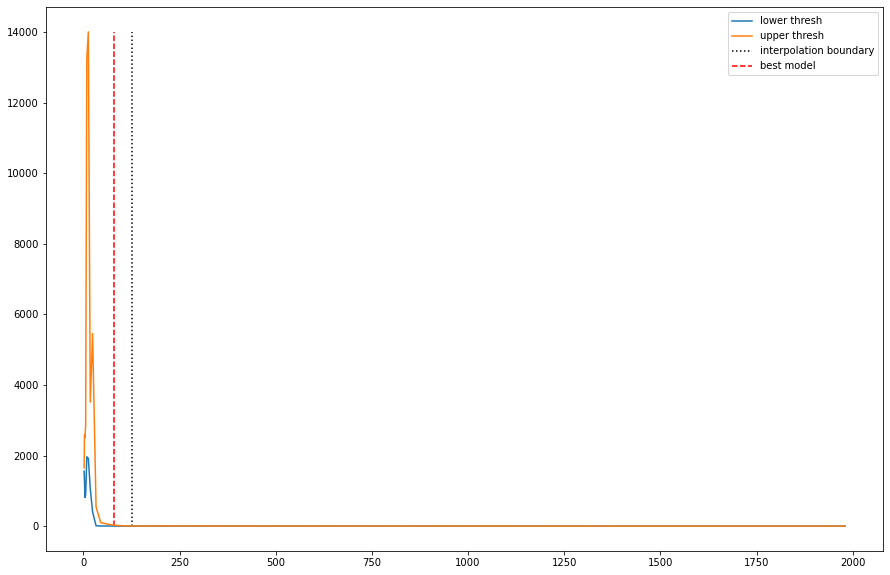

In [47]:
plt.figure(figsize=(15, 10))
plt.plot(lengths[:-1], thresh_l, label="lower thresh")
plt.plot(lengths[:-1], thresh_u, label="upper thresh")
plt.vlines(m*0.7*0.9, 0, max(max(thresh_l), max(thresh_u)), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(np.mean(n_bests), 0, max(max(thresh_l), max(thresh_u)), linestyles="dashed", colors="red", label="best model")
plt.legend(loc="best")
plt.show()

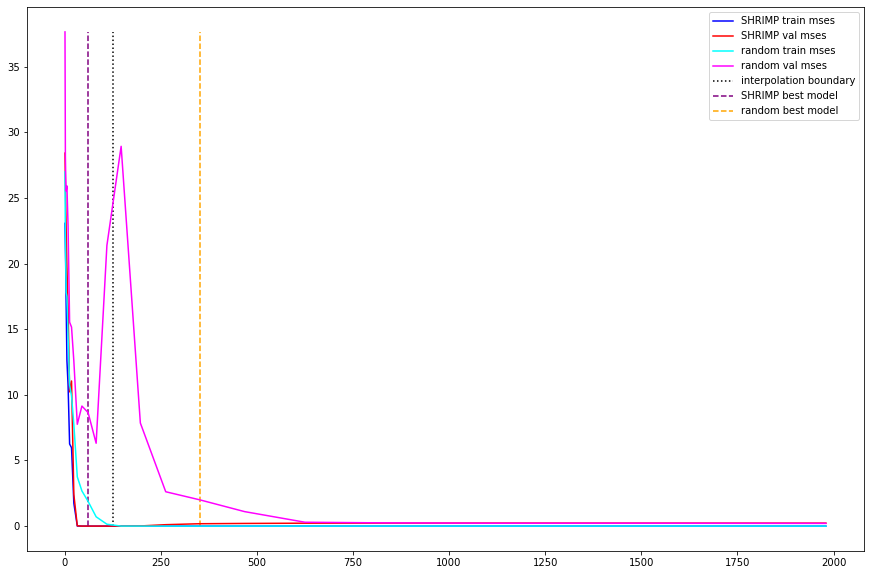

In [48]:
plt.figure(figsize=(15, 10))
plt.plot(lengths, train_mse_s, label="SHRIMP train mses", color="blue")
plt.plot(lengths, val_mse_s, label="SHRIMP val mses", color="red")
plt.plot(lengths, train_mse_r, label="random train mses", color="cyan")
plt.plot(lengths, val_mse_r, label="random val mses", color="magenta")
plt.vlines(m*0.7*0.9, 0, max(max(train_mse_s), max(val_mse_s), max(train_mse_r), max(val_mse_r)), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(best_model.n_best, 0, max(max(train_mse_s), max(val_mse_s), max(train_mse_r), max(val_mse_r)), linestyles="dashed", colors="purple", label="SHRIMP best model")
plt.vlines(best_model_r.n_best, 0, max(max(train_mse_s), max(val_mse_s), max(train_mse_r), max(val_mse_r)), linestyles="dashed", colors="orange", label="random best model")
plt.legend(loc="best")
plt.show()

In [52]:
growth = range(0, 1000, 1)

all_g_train_mses = []
all_g_val_mses = []
errs_g = []
best_lens = []

for _ in range(runs):
    g_train_mses = []
    g_val_mses = []
    best_W = -1
    best_val = np.inf
    best_c = -1
    Xtr1 = Xtr[:int(m*0.7*0.9), :]
    Xval = Xtr[int(m*0.7*0.9):, :]
    Ytr1 = Ytr[:int(m*0.7*0.9)]
    Yval = Ytr[int(m*0.7*0.9):]
    for g in growth:
        W, inds_track = make_W(d, q, N=g, scale=1/np.sqrt(q), sample=False)
        Atr1 = make_A(Xtr1, W)
        Aval = make_A(Xval, W)
        cg = l2(Atr1, Ytr1, l=l)
        val = np.sum(Yval-Aval@cg)**2/len(Yval)
        g_train_mses.append(np.sum(Ytr1-Atr1@cg)**2/len(Ytr1))
        g_val_mses.append(val)
        if val < best_val:
            best_val = val
            best_W = W
            best_c = cg

    Ate = make_A(Xte, best_W)
    err_g = np.sum(Yte-Ate@best_c)**2/len(Yte)

    all_g_train_mses.append(g_train_mses)
    all_g_val_mses.append(g_val_mses)
    errs_g.append(err_g)
    best_lens.append(len(best_c))

g_train_mse = np.mean(all_g_train_mses, axis=0)
g_val_mse = np.mean(all_g_train_mses, axis=0)

In [54]:
print("Err from growth: {}".format(np.mean(errs_g)))

Err from growth: 0.42396367497243953


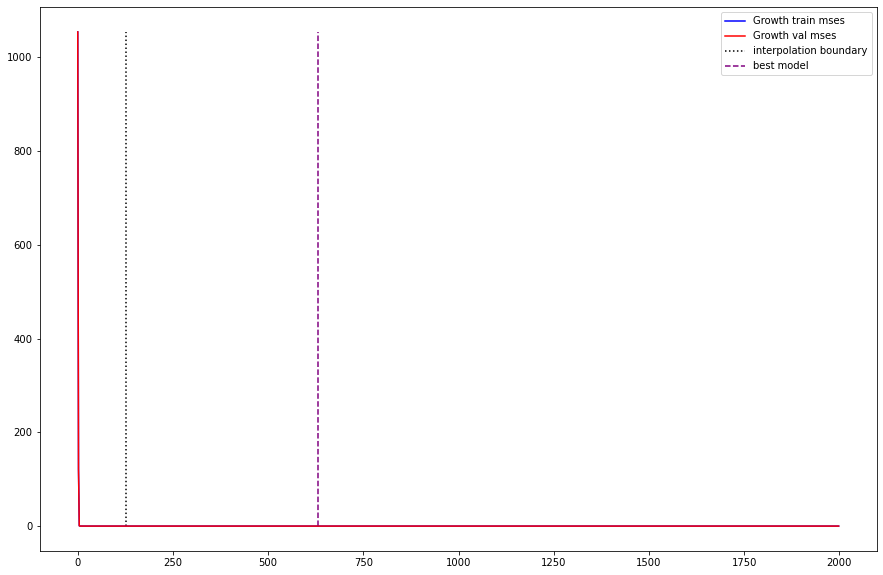

In [55]:
plt.figure(figsize=(15, 10))
plt.plot([g*2 for g in growth], g_train_mse, label="Growth train mses", color="blue")
plt.plot([g*2 for g in growth], g_val_mse, label="Growth val mses", color="red")
plt.vlines(m*0.7*0.9, 0, max(max(g_train_mse), max(g_val_mse)), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(np.mean(best_lens), 0, max(max(g_train_mse), max(g_val_mse)), linestyles="dashed", colors="purple", label="best model")
plt.legend(loc="best")
plt.show()

## $q=d$ (regular KRR)

In [56]:
errs_l2 = []
errs_shrimp = []
errs_r = []

threshs = {'l': [], 'u': []}
n_bests = []

all_train_mses_s = []
all_train_mses_r = []
all_val_mses_s = []
all_val_mses_r = []

for _ in range(runs):
    best_model, train_mses, val_mses, lengths = shrimp(Xtr, Ytr, orderCands=[d], verbose=0, N=N, l=l)
    w_shrimp, Ate_s = shrimp_test(best_model, Xte)
    Atr = make_A(Xtr, best_model.W)
    w_l2 = l2(Atr, Ytr, l=l)
    best_model_r, train_mses_r, val_mses_r, _ = shrimp(Xtr, Ytr, orderCands=[d], verbose=0, N=N, random=True, l=l)
    w_r, Ate_r = shrimp_test(best_model_r, Xte)

    l2_loss_s = make_l2_loss(Ate_s, Yte)
    l2_loss_r = make_l2_loss(Ate_r, Yte)

    errs_shrimp.append(l2_loss_s(w_shrimp))
    errs_l2.append(l2_loss_s(w_l2))
    errs_r.append(l2_loss_r(w_r))

    thresh = list(zip(*list(best_model.thresh.values())))
    threshs['l'].append(thresh[0])
    threshs['u'].append(thresh[1])

    all_train_mses_s.append(train_mses[d])
    all_train_mses_r.append(train_mses_r[d])
    all_val_mses_s.append(val_mses[d])
    all_val_mses_r.append(val_mses_r[d])

    n_bests.append(best_model.n_best)

thresh_l = np.mean(threshs['l'], axis=0)
thresh_u = np.mean(threshs['u'], axis=0)
train_mse_s = np.mean(all_train_mses_s, axis=0)
train_mse_r = np.mean(all_train_mses_r, axis=0)
val_mse_s = np.mean(all_val_mses_s, axis=0)
val_mse_r = np.mean(all_val_mses_r, axis=0)

In [57]:
print("Min l2: {}".format(np.mean(errs_l2)))
print("SHRIMP: {}".format(np.mean(errs_shrimp)))
print("Random pruning: {}".format(np.mean(errs_r)))

Min l2: 0.14553485749277756
SHRIMP: 0.14060245689747547
Random pruning: 0.15041929292418801


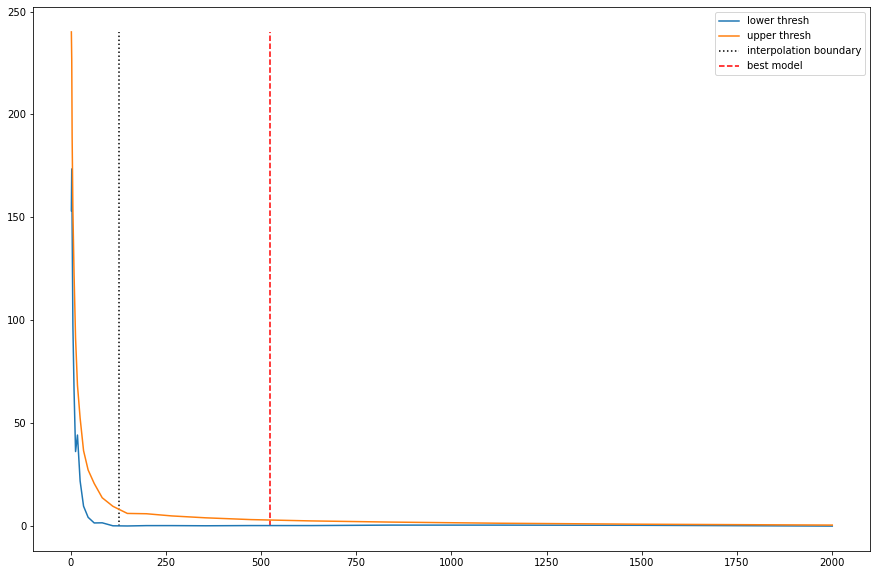

In [58]:
plt.figure(figsize=(15, 10))
plt.plot(lengths[:-1], thresh_l, label="lower thresh")
plt.plot(lengths[:-1], thresh_u, label="upper thresh")
plt.vlines(m*0.7*0.9, 0, max(max(thresh_l), max(thresh_u)), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(np.mean(n_bests), 0, max(max(thresh_l), max(thresh_u)), linestyles="dashed", colors="red", label="best model")
plt.legend(loc="best")
plt.show()

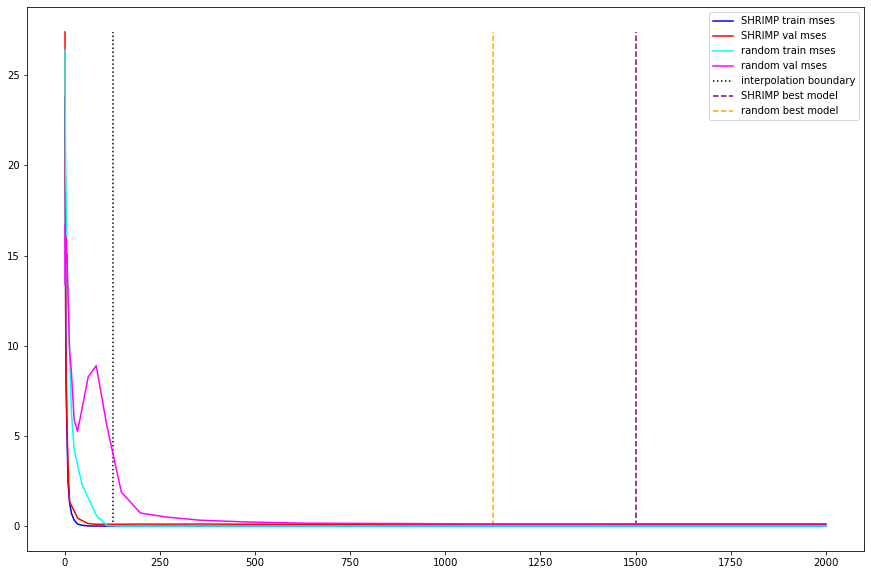

In [59]:
plt.figure(figsize=(15, 10))
plt.plot(lengths, train_mse_s, label="SHRIMP train mses", color="blue")
plt.plot(lengths, val_mse_s, label="SHRIMP val mses", color="red")
plt.plot(lengths, train_mse_r, label="random train mses", color="cyan")
plt.plot(lengths, val_mse_r, label="random val mses", color="magenta")
plt.vlines(m*0.7*0.9, 0, max(max(train_mse_s), max(val_mse_s), max(train_mse_r), max(val_mse_r)), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(best_model.n_best, 0, max(max(train_mse_s), max(val_mse_s), max(train_mse_r), max(val_mse_r)), linestyles="dashed", colors="purple", label="SHRIMP best model")
plt.vlines(best_model_r.n_best, 0, max(max(train_mse_s), max(val_mse_s), max(train_mse_r), max(val_mse_r)), linestyles="dashed", colors="orange", label="random best model")
plt.legend(loc="best")
plt.show()

In [63]:
growth = range(0, 1000, 1)

all_g_train_mses = []
all_g_val_mses = []
errs_g = []
best_lens = []

for _ in range(runs):
    g_train_mses = []
    g_val_mses = []
    best_W = -1
    best_val = np.inf
    best_c = -1
    Xtr1 = Xtr[:int(m*0.7*0.9), :]
    Xval = Xtr[int(m*0.7*0.9):, :]
    Ytr1 = Ytr[:int(m*0.7*0.9)]
    Yval = Ytr[int(m*0.7*0.9):]
    for g in growth:
        W, inds_track = make_W(d, d, N=g, scale=1/np.sqrt(d), sample=False)
        Atr1 = make_A(Xtr1, W)
        Aval = make_A(Xval, W)
        cg = l2(Atr1, Ytr1, l=l)
        val = np.sum(Yval-Aval@cg)**2/len(Yval)
        g_train_mses.append(np.sum(Ytr1-Atr1@cg)**2/len(Ytr1))
        g_val_mses.append(val)
        if val < best_val:
            best_val = val
            best_W = W
            best_c = cg

    Ate = make_A(Xte, best_W)
    err_g = np.sum(Yte-Ate@best_c)**2/len(Yte)

    all_g_train_mses.append(g_train_mses)
    all_g_val_mses.append(g_val_mses)
    errs_g.append(err_g)
    best_lens.append(len(best_c))

g_train_mse = np.mean(all_g_train_mses, axis=0)
g_val_mse = np.mean(all_g_train_mses, axis=0)

In [64]:
print("Err from growth: {}".format(np.mean(errs_g)))

Err from growth: 2.657462691441195


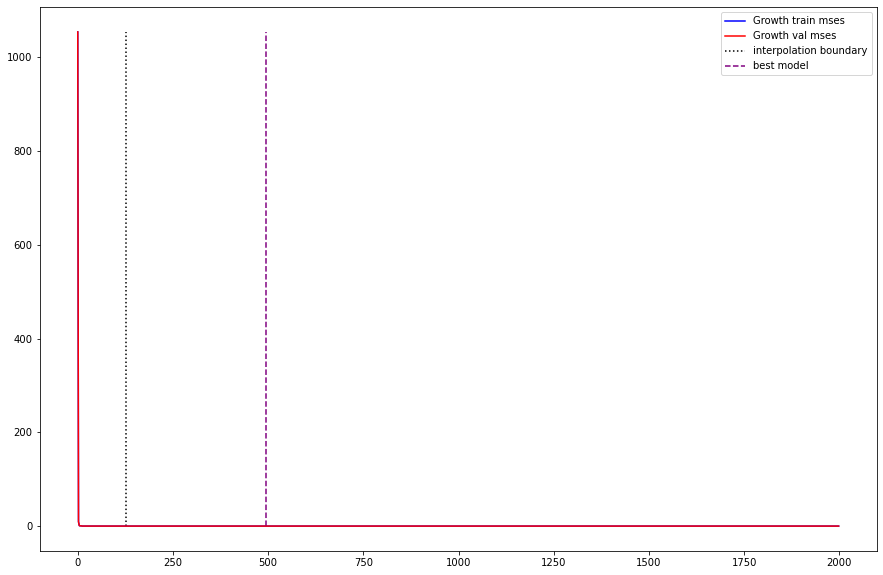

In [65]:
plt.figure(figsize=(15, 10))
plt.plot([g*2 for g in growth], g_train_mse, label="Growth train mses", color="blue")
plt.plot([g*2 for g in growth], g_val_mse, label="Growth val mses", color="red")
plt.vlines(m*0.7*0.9, 0, max(max(g_train_mse), max(g_val_mse)), linestyles="dotted", colors="black", label="interpolation boundary")
plt.vlines(np.mean(best_lens), 0, max(max(g_train_mse), max(g_val_mse)), linestyles="dashed", colors="purple", label="best model")
plt.legend(loc="best")
plt.show()